**Kaggle json file and downloading data on server through kaggle API**


In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

https://www.kaggle.com/datasets/siddharthmandgi/chocolate-classification/code

In [2]:
!kaggle datasets download -d siddharthmandgi/chocolate-classification

 18% 5.00M/27.6M [00:00<00:01, 16.7MB/s]
100% 27.6M/27.6M [00:00<00:00, 70.8MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/chocolate-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

**deleting useless data and anamolous data** 


In [42]:
from pathlib import Path
import imghdr
import os

img_link=list(Path("/content/Chocolate Classification").glob(r'**/*.jpg'))

count_num=0
for lnk in img_link:
    binary_img=open(lnk,'rb')
    find_img=tf.compat.as_bytes('JFIF') in binary_img.peek(10)#The JFIF is a JPEG File Interchange Format (JFIF). It is a standard which we gauge if an image is corrupt or substandard
    if not find_img:
        count_num+=1
        os.remove(str(lnk))
print('Total %d pcs image delete from Dataset' % count_num)

Total 0 pcs image delete from Dataset


**Importing libraries**

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Parameters**

In [44]:
batch_size = 32
img_height = 180
img_width = 180

**Data set importing and splitting**

In [45]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory = '/content/Chocolate Classification',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

validation_ds = tf.keras.utils.image_dataset_from_directory(
  directory = '/content/Chocolate Classification',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 119 files belonging to 2 classes.
Using 96 files for training.
Found 119 files belonging to 2 classes.
Using 23 files for validation.


In [46]:
class_names = train_ds.class_names
print(class_names)

['Dark Chocolate', 'White Chocolate']


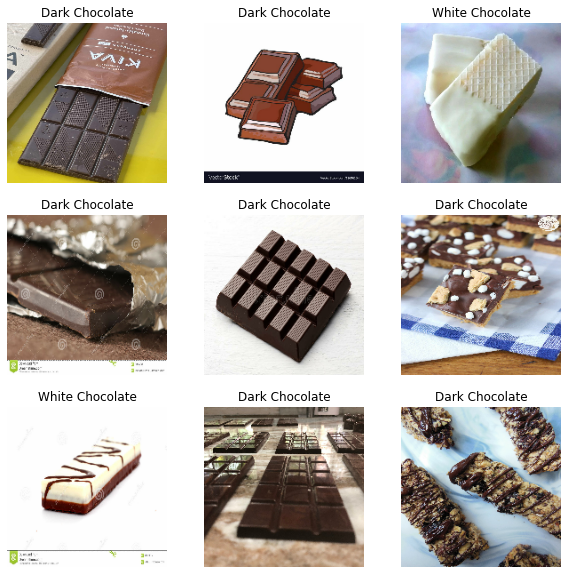

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [48]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


**tuning data to free up chache data** (This will ensure the dataset does not become a bottleneck while training your model)

In [51]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

**normalizing data**

In [52]:
normalization_layer = layers.Rescaling(1./255)

In [53]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


**Data augmentation**

In [60]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

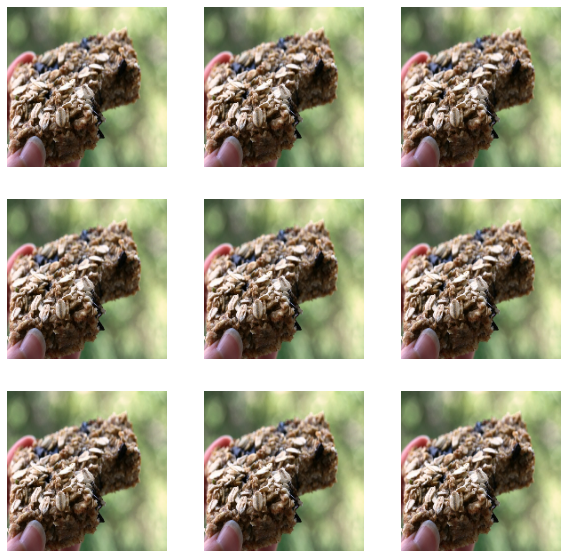

In [63]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Structuring CNN model**

In [64]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [65]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [66]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [67]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
3/3 [==============================] - 5s 1s/step - loss: 2.0413 - accuracy: 0.5521 - val_loss: 3.8971 - val_accuracy: 0.2609
Epoch 2/30
3/3 [==============================] - 3s 1s/step - loss: 1.2714 - accuracy: 0.5625 - val_loss: 0.5801 - val_accuracy: 0.7391
Epoch 3/30
3/3 [==============================] - 3s 1s/step - loss: 0.7381 - accuracy: 0.5729 - val_loss: 1.1855 - val_accuracy: 0.2609
Epoch 4/30
3/3 [==============================] - 3s 1s/step - loss: 0.6272 - accuracy: 0.5938 - val_loss: 0.7628 - val_accuracy: 0.4783
Epoch 5/30
3/3 [==============================] - 3s 1s/step - loss: 0.5181 - accuracy: 0.8438 - val_loss: 0.8600 - val_accuracy: 0.5652
Epoch 6/30
3/3 [==============================] - 3s 1s/step - loss: 0.4944 - accuracy: 0.8333 - val_loss: 0.8856 - val_accuracy: 0.6087
Epoch 7/30
3/3 [==============================] - 3s 1s/step - loss: 0.4005 - accuracy: 0.9167 - val_loss: 0.7161 - val_accuracy: 0.6957
Epoch 8/30
3/3 [=========================

**Accuracy ploting**

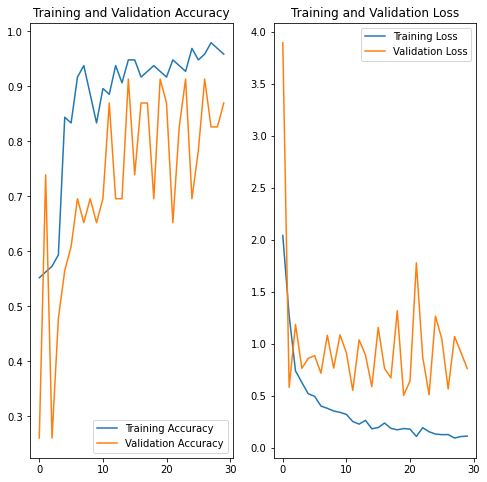

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


**Testing on 3 outsourced example images**

In [69]:
testpic1_path = '/content/testdarkchoco.jpg'

img = tf.keras.utils.load_img(
    testpic1_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 94ms/step
This image most likely belongs to Dark Chocolate with a 100.00 percent confidence.


In [70]:
testpic2_path = '/content/testdarkchoco.jpg'

img = tf.keras.utils.load_img(
    testpic2_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 40ms/step
This image most likely belongs to Dark Chocolate with a 100.00 percent confidence.


In [71]:
testpic3_path = '/content/testWhitechoco.jpeg'

img = tf.keras.utils.load_img(
    testpic3_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 40ms/step
This image most likely belongs to White Chocolate with a 98.41 percent confidence.
